# Step-by-step demonstration

## Lib Imports and configurations

In [1]:
# %matplotlib notebook
# %matplotlib inline 
%load_ext autoreload
%autoreload 2

import sys
import os
import glob
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from ruptures.metrics import precision_recall, meantime
import scipy.stats as ss
from itertools import islice

sys.path.append("Codes/")

import TMPD_utils
import TMPD_class

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)
# pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
pd.options.display.float_format = '{:.4f}'.format


## Loading event log

In [2]:
# Mapping all event_logs paths
logs_path = glob.glob("Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange/*/*/*/*/*.mxml.gz")

# Temp filter
logs_path = [x for x in logs_path if "_2" not in x and "_5" not in x and "Size1" in x and "Atomic" in x]

# Showing mapped paths
print("How many logs? ", len(logs_path))
pd.DataFrame(logs_path)

How many logs?  13


,0
0,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ConditionalMove\output\ConditionalMove.mxml.gz
1,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ConditionalRemoval\output\ConditionalRemoval.mxml.gz
2,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ConditionalToSequence\output\ConditionalToSequence.mxml.gz
3,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\Frequency\output\Frequency.mxml.gz
4,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\Loop\output\Loop.mxml.gz
5,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ParallelMove\output\ParallelMove.mxml.gz
6,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ParallelRemoval\output\ParallelRemoval.mxml.gz
7,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ParallelToSequence\output\ParallelToSequence.mxml.gz
8,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\SerialMove\output\SerialMove.mxml.gz
9,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\SerialRemoval\output\SerialRemoval.mxml.gz


<!-- ![Alt text](../Images/Concept_drift_firstcycle_steps_eng.png "General steps") -->

In [3]:
# Loading first event log
log_path = logs_path[12]
print(log_path)
print(log_path.split("\\")[-5] + "/" + log_path.split("\\")[-1].split(".")[0])
event_log = TMPD_utils.parse_mxml(log_path, gzip=True)

# This is a specifc step for this event log that remove an activity that shows where the drift happens
event_log = event_log[event_log['WorkflowModelElement'] != 'DRIFT_PO']

# Save original event index
event_log = event_log.reset_index(names='original_index') 

# Create an id based on the order of the event in the raw event log
event_log["Event_order_id"] = event_log.index

# Showing loaded event log
print("Total events: ", len(event_log))
print("Total cases: ", len(event_log.groupby('CaseId')))
print("Total activities: ", len(event_log.groupby('Activity')))
event_log.head(30)

Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\Swap\output\Swap.mxml.gz
Size1/Swap
Total events:  67195
Total cases:  2999
Total activities:  25


,original_index,CaseId,Data,WorkflowModelElement,EventType,timestamp,Activity,Event_order_id
0,0,1,1970-01-01T10:33:47.462+10:00,a,complete,1970-01-01T10:33:47.462+10:00,a,0
1,1,1,1970-01-01T11:28:08.980+10:00,e,complete,1970-01-01T11:28:08.980+10:00,e,1
2,2,1,1970-01-01T11:32:51.926+10:00,d,complete,1970-01-01T11:32:51.926+10:00,d,2
3,3,1,1970-01-01T11:39:34.303+10:00,c,complete,1970-01-01T11:39:34.303+10:00,c,3
4,4,1,1970-01-01T12:32:42.811+10:00,i,complete,1970-01-01T12:32:42.811+10:00,i,4
5,5,1,1970-01-01T13:29:14.845+10:00,j,complete,1970-01-01T13:29:14.845+10:00,j,5
6,6,1,64,k,complete,1970-01-01T14:25:40.585+10:00,k,6
7,7,1,73,s,complete,1970-01-01T15:20:38.211+10:00,s,7
8,8,1,1970-01-01T15:24:08.336+10:00,m,complete,1970-01-01T15:24:08.336+10:00,m,8
9,9,1,1970-01-01T15:24:10.079+10:00,l,complete,1970-01-01T15:24:10.079+10:00,l,9


## Step 1 - Instantiating class and setting event log

In [4]:
# Iniatializing the TMPD_class
TMPD_instance = TMPD_class.TMPD(scenario='offline')

# Setting the transition log
TMPD_instance.set_transition_log(event_log, case_id='CaseId', activity_key='Activity', timestamp_key='timestamp', timestamp_format=None, other_columns_keys=[])

# Executing the transition log
TMPD_instance.run_transition_log()

# Showing the transition log created
print(len(TMPD_instance.get_transition_log()))
TMPD_instance.get_transition_log().head(30)

70194


,original_index,case_id,activity_from,timestamp_from,activity_to,timestamp_to,transition_id,case_order
0,67195,1,START,1970-01-01T10:33:47.462+10:00,a,1970-01-01T10:33:47.462+10:00,0,0
1,0,1,a,1970-01-01T10:33:47.462+10:00,e,1970-01-01T11:28:08.980+10:00,1,1
2,1,1,e,1970-01-01T11:28:08.980+10:00,d,1970-01-01T11:32:51.926+10:00,2,2
3,2,1,d,1970-01-01T11:32:51.926+10:00,c,1970-01-01T11:39:34.303+10:00,3,3
4,3,1,c,1970-01-01T11:39:34.303+10:00,i,1970-01-01T12:32:42.811+10:00,4,4
5,4,1,i,1970-01-01T12:32:42.811+10:00,j,1970-01-01T13:29:14.845+10:00,5,5
6,5,1,j,1970-01-01T13:29:14.845+10:00,k,1970-01-01T14:25:40.585+10:00,6,6
7,6,1,k,1970-01-01T14:25:40.585+10:00,s,1970-01-01T15:20:38.211+10:00,7,7
8,7,1,s,1970-01-01T15:20:38.211+10:00,m,1970-01-01T15:24:08.336+10:00,8,8
9,8,1,m,1970-01-01T15:24:08.336+10:00,l,1970-01-01T15:24:10.079+10:00,9,9


## Step 2 - Setting Window Strategy

In [5]:
# Setting the window strategy parameters
TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 8000, window_ref_mode = 'Fixed', overlap = True, sliding_step = 2000, continuous = True)

# Executing the window strategy indexation
TMPD_instance.run_windowing_strategy()

# Showing the windows indexes
dict(list(TMPD_instance.get_windowing_strategy().items())[:15])

{0: {'start': 0, 'end': 8000, 'window_index': 0},
 1: {'start': 2000, 'end': 10000, 'window_index': 1},
 2: {'start': 4000, 'end': 12000, 'window_index': 2},
 3: {'start': 6000, 'end': 14000, 'window_index': 3},
 4: {'start': 8000, 'end': 16000, 'window_index': 4},
 5: {'start': 10000, 'end': 18000, 'window_index': 5},
 6: {'start': 12000, 'end': 20000, 'window_index': 6},
 7: {'start': 14000, 'end': 22000, 'window_index': 7},
 8: {'start': 16000, 'end': 24000, 'window_index': 8},
 9: {'start': 18000, 'end': 26000, 'window_index': 9},
 10: {'start': 20000, 'end': 28000, 'window_index': 10},
 11: {'start': 22000, 'end': 30000, 'window_index': 11},
 12: {'start': 24000, 'end': 32000, 'window_index': 12},
 13: {'start': 26000, 'end': 34000, 'window_index': 13},
 14: {'start': 28000, 'end': 36000, 'window_index': 14}}

## Step 3 - Setting Process Representation (using Transition Matrix)

In [6]:
# Setting the Transition Matrix (TM) process representation
TMPD_instance.set_process_representation(threshold_anomaly=0.0025
                                    , control_flow_features={'frequency', 'probability' } #, 'causality', 'parallel'
                                    , time_features={} #'avg_time':'timestamp', 'time_std':'timestamp'
                                    , resource_features={}
                                    , data_features={})

# Executing the process_representation using all dataset just for an example
TMPD_instance.run_process_representation(TMPD_instance.transition_log)

# Showing the process representation created
TMPD_instance.get_process_representation() #.head(15)

probability  frequency
activity_from activity_to                        
START         a                 0.5042       1512
              b                 0.4958       1487
a             c                 0.3168        479
              d                 0.3505        530
              e                 0.3327        503
b             f                 0.3349        498
              g                 0.3403        506
              h                 0.3248        483
c             d                 0.3075        465
              e                 0.3353        507
              i                 0.3571        540
d             c                 0.3532        534
              e                 0.3320        502
              i                 0.3148        476
e             c                 0.3300        499
              d                 0.3419        517
              i                 0.3280        496
f             g                 0.3235        481
              h                 0.3336        496
              i                 0.3430        510
g             f                 0.3093        460
              h                 0.3416        508
              i                 0.3490        519
h             f                 0.3557        529
              g                 0.3362        500
              i                 0.3080        458
i             j                 1.0000       2999
j             k                 1.0000       4252
k             j                 0.2947       1253
              l                 0.2366       1006
              m                 0.2335        993
              s                 0.2352       1000
l             m                 0.3294        988
              r                 0.1627        488
              s                 0.3344       1003
              t                 0.1734        520
m             l                 0.3264        979
              r                 0.1634        490
              s                 0.3324        997
              t                 0.1777        533
n             o                 0.6682       2004
              u                 0.3318        995
o             n                 0.3318        995
              p                 0.6682       2004
p             o                 0.3318        995
              u                 0.6682       2004
r             s                 1.0000       2939
s             l                 0.1706       1013
              m                 0.1714       1018
              r                 0.3304       1962
              t                 0.3277       1946
t             n                 0.6682       2004
              p                 0.3318        995
u             v                 0.5012       2171
              w                 0.4988       2161
v             u                 0.3174        689
              y                 0.6826       1482
w             x                 1.0000       2161
x             u                 0.2980        644
              y                 0.7020       1517
y             z                 1.0000       2999
z             END               1.0000       2999

## Step 4 - Setting Change Representation

In [7]:
# Defining the change features
change_features_strategy_dict = {
    'delta_matrix_strategy': 
        {
            'frequency_delta' : {'process_feature':'frequency', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'probability_delta' : {'process_feature':'probability', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'causality_delta' : {'process_feature':'causality', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'parallel_delta' : {'process_feature':'parallel', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'frequency_delta_percentage' : {'process_feature':'frequency', 'method':'percentage'}
            , 'prob_freq_delta_weight' : {'process_feature':'probability', 'method':'aggregation_weight', 'agg_function' : 'sum', 'weight_feature' : 'frequency'}
            # , 'avg_time_delta' : {'process_feature':'avg_time', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'time_std_delta' : {'process_feature':'time_std', 'method':'aggregation', 'agg_function' : 'sum'}
        }
    , 'statistic_test_strategy' : 
        {
            'frequency_gtest_pvalue' : {'process_feature':'frequency', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            , 'frequency_cramersv' : {'process_feature':'frequency', 'method':'cramers_v', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
        }
    }

# Setting Change Representation
TMPD_instance.set_change_representation(change_features_strategy_dict)

# Executing the Change Representation using the window strategy
TMPD_instance.run_change_representation()

# Showing the Change Representation created
TMPD_instance.get_change_representation().head(30)

,start,end,window_index,reference_window_index,frequency_delta,probability_delta,frequency_delta_percentage,prob_freq_delta_weight,frequency_gtest_pvalue,frequency_cramersv
0,0,8000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,10000,1,0,314.0000,0.9683,0.0196,6.8378,1.0000,0.0000
2,4000,12000,2,0,464.0000,1.2870,0.0290,14.5708,0.9999,0.0000
3,6000,14000,3,0,604.0000,1.4831,0.0377,20.6726,0.9328,0.0000
4,8000,16000,4,0,544.0000,1.5774,0.0340,20.6085,0.9860,0.0000
5,10000,18000,5,0,624.0000,1.6208,0.0390,21.9638,0.9492,0.0000
6,12000,20000,6,0,515.0000,1.5134,0.0322,19.5710,0.9898,0.0000
7,14000,22000,7,0,469.0000,1.3198,0.0293,15.5343,0.9993,0.0000
8,16000,24000,8,0,1153.0000,3.2660,0.0721,172.7778,0.0000,0.1499
9,18000,26000,9,0,1887.0000,5.4668,0.1179,673.8825,0.0000,0.2446


## Step 5 - Setting Detection Task

In [8]:
# Defining detection strategies
detection_task_strategy_dict = {
    'time_series_strategy': 
    {
        'cpd_frequency_delta' : {'change_features':['frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_prob_freq_delta' : {'change_features':['prob_freq_delta_weight'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_causality_delta' : {'change_features':['causality_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_parallel_delta' : {'change_features':['parallel_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_avg_time_delta' : {'change_features':['avg_time_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_time_std_delta' : {'change_features':['time_std_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
    }
    , 'threshold_strategy' : 
    {
        'gtest_frequency' : {'change_features':['frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' : '3'}
        , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
        # , 'fixed_frequency_delta_percentage' : {'change_features':['frequency_delta_percentage'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
    }
}

# Setting Detection Task
TMPD_instance.set_detection_task(detection_task_strategy_dict)

# Executing the Detection Task
TMPD_instance.run_detection_task()

# Showing Detection Task Results
TMPD_instance.get_detection_task()


,detection_strategy,detection_feature,detection_results
0,time_series_strategy,cpd_frequency_delta,"[11, 22, 32]"
1,time_series_strategy,cpd_prob_freq_delta,"[11, 22, 32]"
2,time_series_strategy,cramersv_frequency,"[10, 23, 32]"
3,threshold_strategy,cramersv_frequency,"[8, 23, 32]"
4,threshold_strategy,gtest_frequency,"[8, 23, 32]"


In [9]:
ground_truth_traces_indexes = ["1000", "2000"]

transition_log = TMPD_instance.get_transition_log()
ground_truth_events_indexes = transition_log[transition_log['case_id'].isin(ground_truth_traces_indexes)].groupby('case_id').first()['transition_id'].to_list()

# signals_indexes = signals.reset_index()
signals = TMPD_instance.get_change_representation()
ground_truth = []
for ground_truth_events_index in ground_truth_events_indexes:
    ground_truth.extend(signals[(signals['start'] <= ground_truth_events_index) 
                & (signals['end'] >= ground_truth_events_index)].head(1).index.to_list())
ground_truth = ground_truth + [len(signals)]

In [10]:
# Grounding truth
log_size = event_log['CaseId'].nunique()
ground_truth_traces_indexes = ["1000", "2000"]

transition_log = TMPD_instance.get_transition_log()
ground_truth_events_indexes = transition_log[transition_log['case_id'].isin(ground_truth_traces_indexes)].groupby('case_id').first()['transition_id'].to_list()
print(ground_truth_events_indexes)

# signals_indexes = signals.reset_index()
signals = TMPD_instance.get_change_representation()
ground_truth = []
for ground_truth_events_index in ground_truth_events_indexes:
    ground_truth.extend(signals[(signals['start'] <= ground_truth_events_index) 
                & (signals['end'] >= ground_truth_events_index)].head(1).index.to_list())
ground_truth = ground_truth + [len(signals)]
print("ground_truth: ", ground_truth)

[23398, 46727]
ground_truth:  [8, 20, 32]


In [11]:
### Validation metrics
margin_error_defined=3
detection_task_results = TMPD_instance.get_detection_task()
for index, row in detection_task_results.iterrows():
    try:
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)

        # smooth = int(detection_task_strategy_dict[row['detection_strategy']][row['detection_feature']]['smooth'])

        # Margin of error give more margin to overlap if used.
        margin_error = int(margin_error_defined + 1)  if TMPD_instance.overlap == False else int(margin_error_defined + 1 + TMPD_instance.window_size/TMPD_instance.sliding_step)

        precision, recall = precision_recall(ground_truth, row['detection_results'], margin=margin_error)

        f1 = round(ss.hmean([precision, recall]),2)
        detection_task_results.loc[index, 'f1'] = f1
        
        delay = round(meantime(ground_truth, row['detection_results']), 2)
        detection_task_results.loc[index, 'delay'] = delay

    except Exception as e:
        print("Error:", e)
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)
        detection_task_results.loc[index, 'f1'] = np.nan
        detection_task_results.loc[index, 'delay'] = np.nan

detection_task_results

,detection_strategy,detection_feature,detection_results,ground_truth,f1,delay
0,time_series_strategy,cpd_frequency_delta,"[11, 22, 32]","[8, 20, 32]",1.0000,2.5000
1,time_series_strategy,cpd_prob_freq_delta,"[11, 22, 32]","[8, 20, 32]",1.0000,2.5000
2,time_series_strategy,cramersv_frequency,"[10, 23, 32]","[8, 20, 32]",1.0000,2.5000
3,threshold_strategy,cramersv_frequency,"[8, 23, 32]","[8, 20, 32]",1.0000,1.5000
4,threshold_strategy,gtest_frequency,"[8, 23, 32]","[8, 20, 32]",1.0000,1.5000


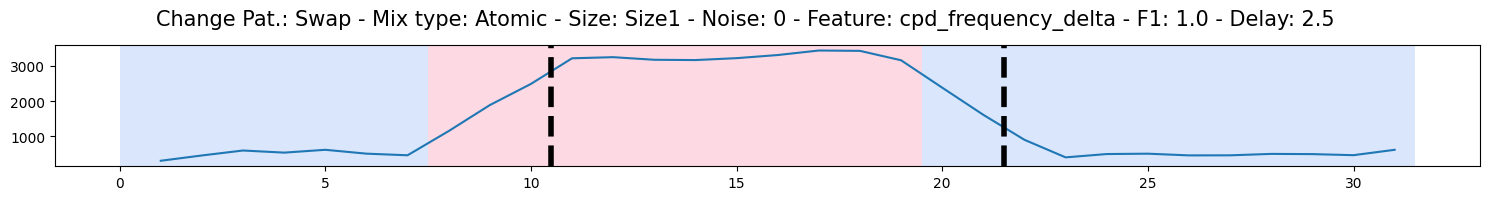

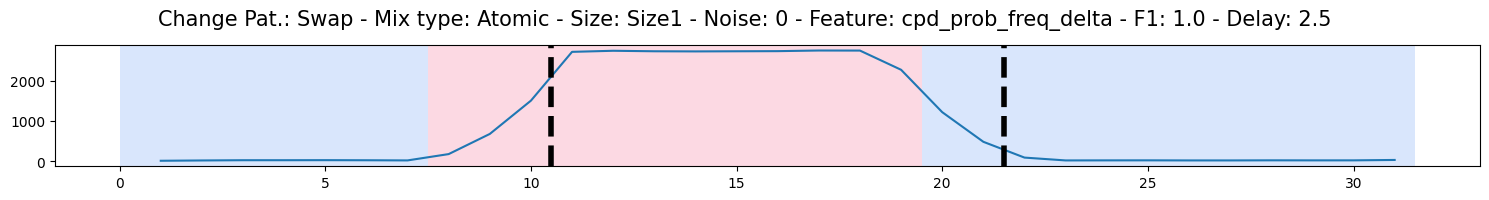

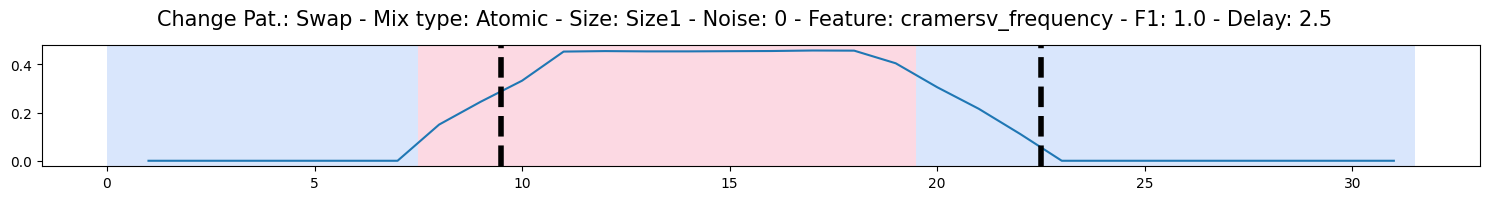

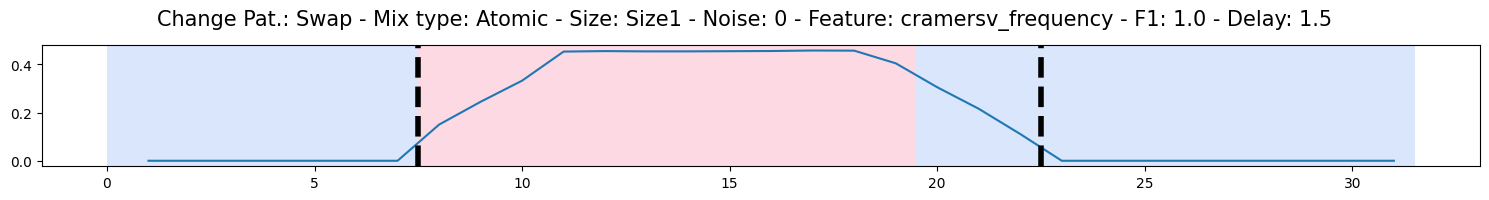

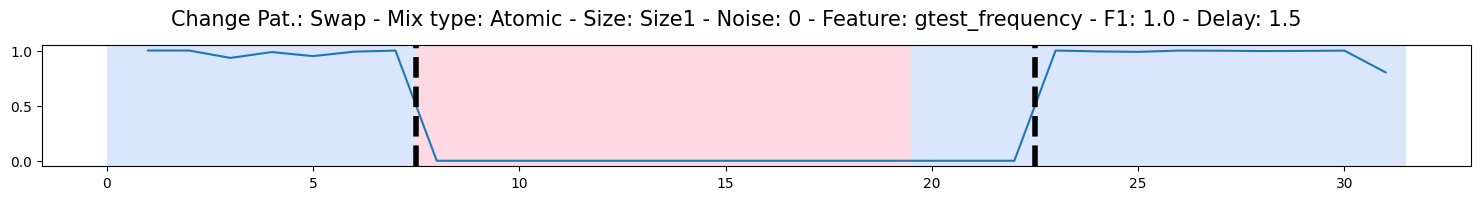

In [12]:
# Display Detection Task Results 
Noise = log_path.split("\\")[-1].split(".")[0].split("_")[-1] if log_path.split("\\")[-1].split(".")[0].split("_")[-1].isdigit() else 0

for result in detection_task_results.itertuples():
    fig, axarr = rpt.display(signal = TMPD_instance.get_change_representation()[TMPD_instance.detection_task_strategy_dict[result.detection_strategy][result.detection_feature]['change_features']]
                , true_chg_pts=ground_truth
                , computed_chg_pts = result.detection_results
                , computed_chg_pts_color = "k"
                , computed_chg_pts_linewidth = 4
                , computed_chg_pts_linestyle = "--"
                , computed_chg_pts_alpha = 1
                , figsize=(15, 2)
                )
    plt.suptitle("Change Pat.: " + str(log_path.split("\\")[-3])   
                 + " - Mix type: " + str(log_path.split("\\")[-4])  
                 + " - Size: " + str(log_path.split("\\")[-5]) 
                 + " - Noise: " + str(Noise)
                 + " - Feature: " + str(result.detection_feature) 
                 + " - F1: " + str(result.f1) 
                 + " - Delay: " + str(result.delay)
                 , fontsize=15)
    plt.subplots_adjust(top=0.8)
    plt.show()

## Step 6a - Setting Localization Task

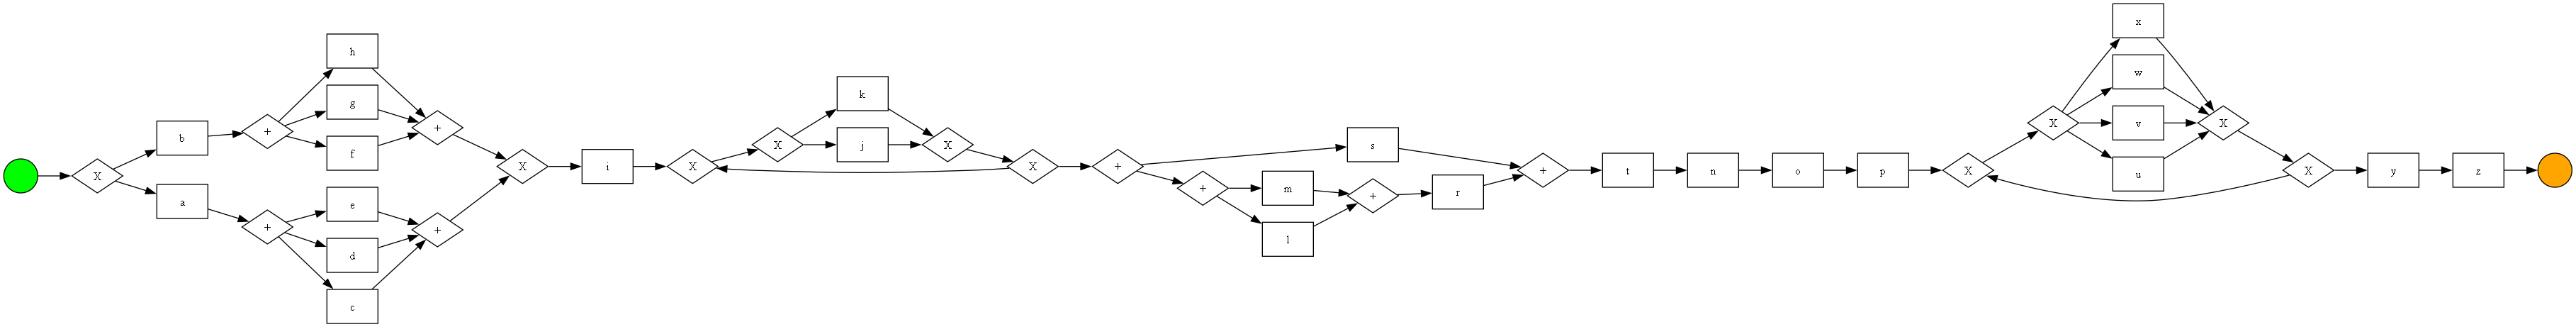

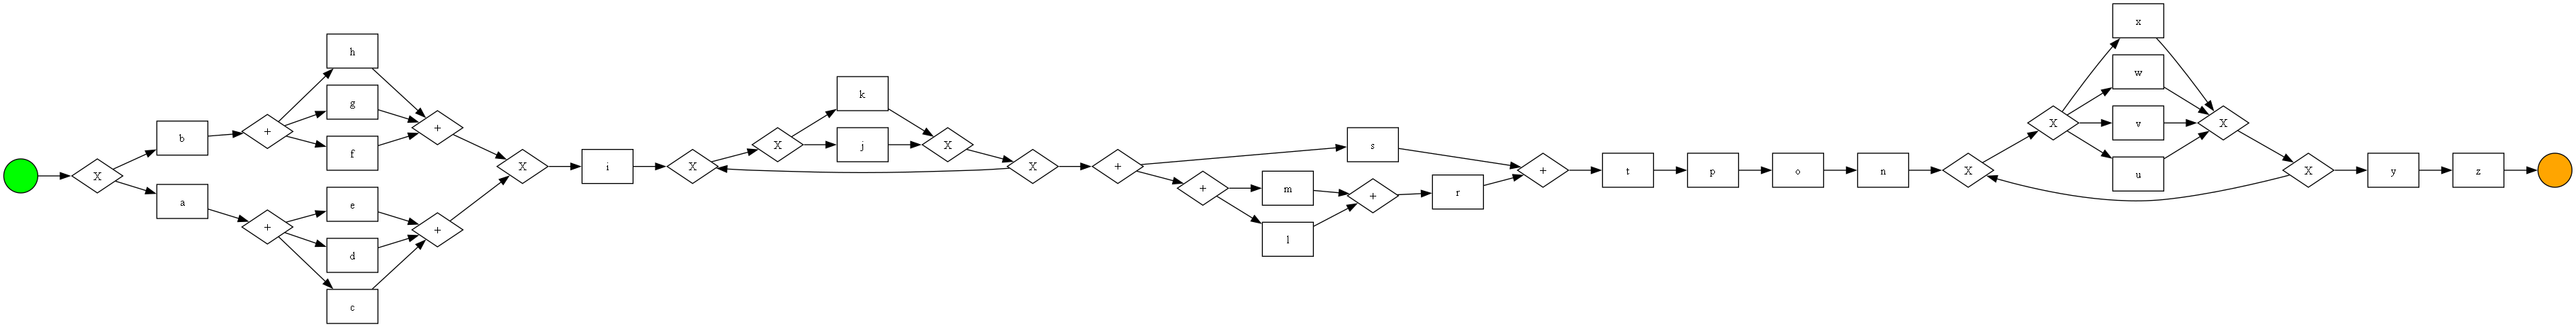

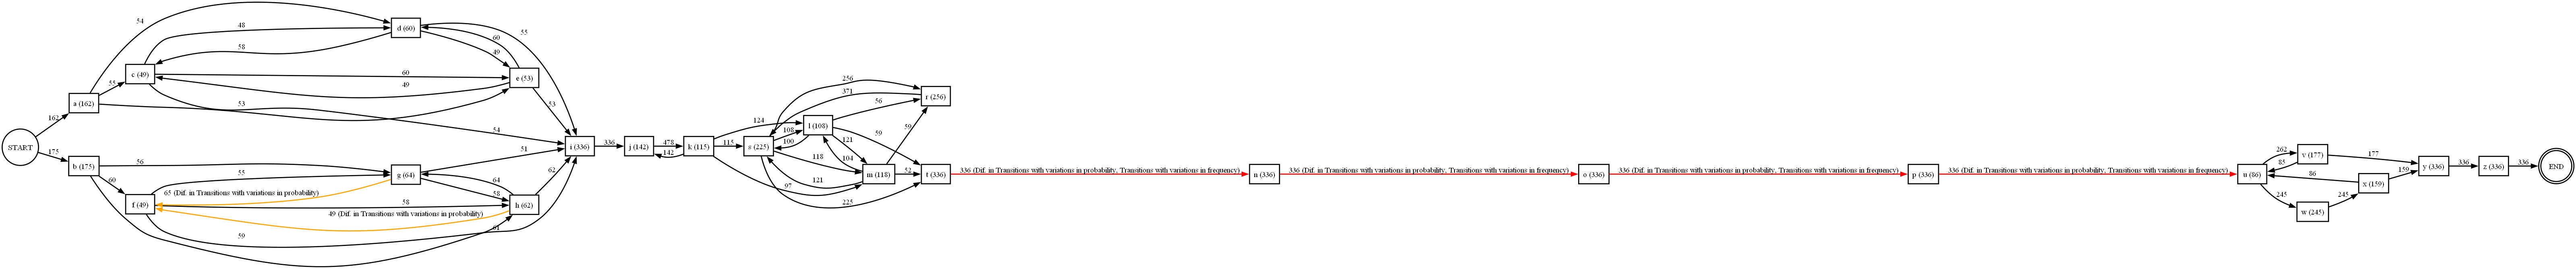

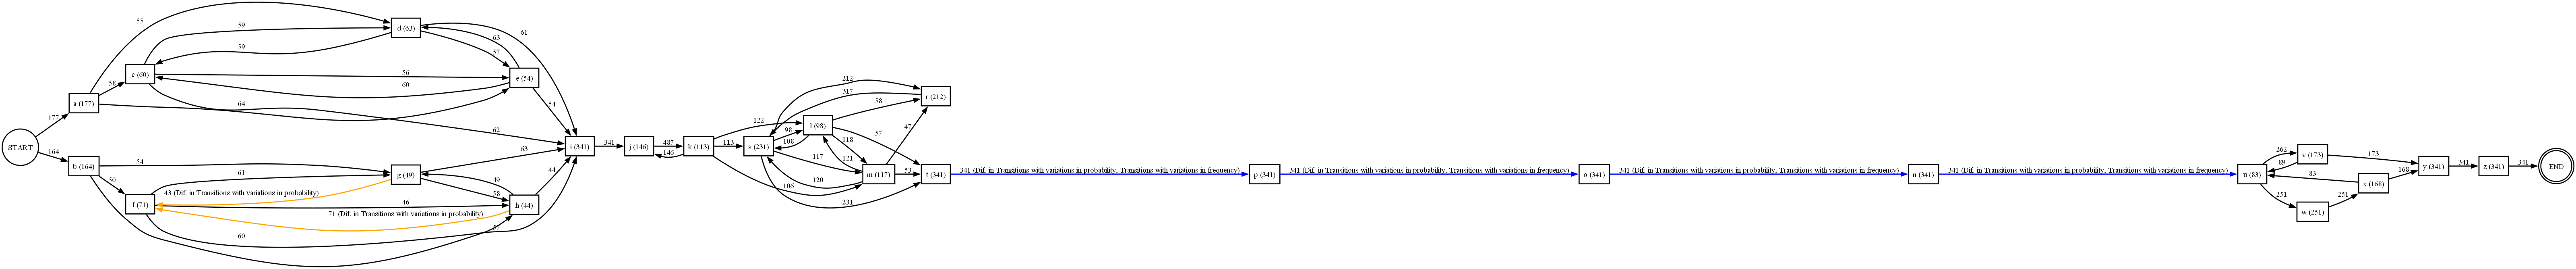

(   transition      feature  p_value  effect_size  ref_value  det_value  \
 0      (g, f)  probability   0.0350       0.2400     0.3736     0.2622   
 1      (h, f)  probability   0.0038      -0.3210     0.2800     0.4329   
 2      (n, o)  probability   0.0000       3.1416     1.0000     0.0000   
 3      (n, o)    frequency   0.0000       0.1704   336.0000     0.0000   
 4      (o, p)  probability   0.0000       3.1416     1.0000     0.0000   
 5      (o, p)    frequency   0.0000       0.1704   336.0000     0.0000   
 6      (p, u)  probability   0.0000       3.1416     1.0000     0.0000   
 7      (p, u)    frequency   0.0000       0.1704   336.0000     0.0000   
 8      (t, n)  probability   0.0000       3.1416     1.0000     0.0000   
 9      (t, n)    frequency   0.0000       0.1704   336.0000     0.0000   
 10     (n, u)  probability   0.0000      -3.1416     0.0000     1.0000   
 11     (n, u)    frequency   0.0000       0.1717     0.0000   341.0000   
 12     (o, n)  probabili

In [13]:
# Setting Localization Task
TMPD_instance.set_localization_task(reference_window_index=0, detection_window_index=14, pvalue_threshold=0.05, effect_prop_threshold=0.2, effect_count_threshold=0.02, pseudo_count=5)

# Executing Localization Task
TMPD_instance.run_localization_task()

# Showing Localization Task Results
TMPD_instance.get_localization_task(show_localization_dfg=True, show_original_dfg=False, show_original_bpmn=True)

In [14]:
### Ground Truth
change_pattern_ground_truth = log_path.split("\\")[-3]

change_activities_ground_truth = {
    'ConditionalMove': {
        'change_pattern_name': 'CM',
        'characterization_activities': ['Prepare_acceptance_pack'],
        'localization_activities': ['Send_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', 'Prepare_acceptance_pack', 'Assess_eligibility', 'Send_home_insurance_quote', 'Verify_repayment_agreement']
    },
    'ConditionalRemoval': {
        'change_pattern_name': 'CRE',
        'characterization_activities': ['Prepare_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', 'Verify_repayment_agreement'],
        'localization_activities': ['Send_acceptance_pack', 'Cancel_application', 'Check_if_home_insurance_quote_is_requested', 'Approve_application', 'Prepare_acceptance_pack', 'Assess_eligibility', 'Send_home_insurance_quote', 'Verify_repayment_agreement']
    },
    'ConditionalToSequence': {
        'change_pattern_name': 'CF',
        'characterization_activities': ['Send_home_insurance_quote', 'Send_acceptance_pack'],
        'localization_activities': ['Check_if_home_insurance_quote_is_requested', 'Send_home_insurance_quote', 'Send_acceptance_pack', 'Verify_repayment_agreement']
    },
    'Frequency': {
        'change_pattern_name': 'FR',
        'characterization_activities': ['Check_if_home_insurance_quote_is_requested', 'Send_acceptance_pack', 'Send_home_insurance_quote'],
        'localization_activities': ['Check_if_home_insurance_quote_is_requested', 'Send_home_insurance_quote', 'Send_acceptance_pack', 'Verify_repayment_agreement']
    },
    'Loop': {
        'change_pattern_name': 'LP',
        'characterization_activities': ['Assess_loan_risk', 'Appraise_property', 'Assess_eligibility', 'Check_credit_history'],
        'localization_activities': ['Assess_loan_risk', 'Appraise_property', 'Assess_eligibility', 'Check_credit_history', 'Reject_application', 'Prepare_acceptance_pack']
    },
    'ParallelMove': {
        'change_pattern_name': 'PM',
        'characterization_activities': ['Prepare_acceptance_pack', 'Send_home_insurance_quote'],
        'localization_activities': ['Send_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', 'Prepare_acceptance_pack', 'Assess_eligibility', 'Send_home_insurance_quote', 'Verify_repayment_agreement']
    },
    'ParallelRemoval': {
        'change_pattern_name': 'PRE',
        'characterization_activities': ['Prepare_acceptance_pack', 'Send_home_insurance_quote'],
        'localization_activities': ['Send_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', 'Prepare_acceptance_pack', 'Assess_eligibility', 'Send_home_insurance_quote', 'Verify_repayment_agreement']
    },
    'ParallelToSequence': {
        'change_pattern_name': 'PL',
        'characterization_activities': ['Appraise_property', 'Check_credit_history', 'Assess_loan_risk'],
        'localization_activities': ['Assess_loan_risk', 'Check__application__form_completeness', 'Appraise_property', 'Assess_eligibility', 'Check_credit_history']
    },
    'SerialMove': {
        'change_pattern_name': 'SM',
        'characterization_activities': ['Assess_eligibility'],
        'localization_activities': ['Assess_eligibility', 'Reject_application', 'Prepare_acceptance_pack', 'Assess_loan_risk', 'Appraise_property']
    },
    'SerialRemoval': {
        'change_pattern_name': 'SRE',
        'characterization_activities': ['Assess_eligibility'],
        'localization_activities': ['Assess_eligibility', 'Reject_application', 'Prepare_acceptance_pack', 'Assess_loan_risk', 'Appraise_property']
    },
    'Skip': {
        'change_pattern_name': 'CB',
        'characterization_activities': ['Check_if_home_insurance_quote_is_requested', 'Prepare_acceptance_pack'],
        'localization_activities': ['Send_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', 'Prepare_acceptance_pack', 'Assess_eligibility', 'Send_home_insurance_quote']
    },
    'Substitute': {
        'change_pattern_name': 'RP',
        'characterization_activities': ['Verify_repayment_agreement', 'Replaced_Activity'],
        'localization_activities': ['Cancel_application', 'Send_acceptance_pack', 'Replaced_Activity', 'Approve_application', 'Send_home_insurance_quote', 'Verify_repayment_agreement']
    },
    'Swap': {
        'change_pattern_name': 'SW',
        'characterization_activities': ['Prepare_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', 'Verify_repayment_agreement'],
        'localization_activities': ['Send_acceptance_pack', 'Cancel_application', 'Check_if_home_insurance_quote_is_requested', 'Approve_application', 'Prepare_acceptance_pack', 'Assess_eligibility', 'Send_home_insurance_quote', 'Verify_repayment_agreement']
    } 
}

localization_ground_truth = change_activities_ground_truth[change_pattern_ground_truth]['localization_activities']
localization_ground_truth

['Send_acceptance_pack',
 'Cancel_application',
 'Check_if_home_insurance_quote_is_requested',
 'Approve_application',
 'Prepare_acceptance_pack',
 'Assess_eligibility',
 'Send_home_insurance_quote',
 'Verify_repayment_agreement']

In [15]:
### Validation metrics

# Getting the distinct activities in the Localization Result
localization_distinct_activities = set()
for key, value in islice(TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[1].items(), 6):
    if isinstance(value, list): # Check if the value is a list
        # Skip the list if it contains only "None"
        if len(value) == 1 and value[0] == "None":
            continue
        for item in value:
            if isinstance(item, tuple): # If the items are tuples, extend the set with the tuple items
                localization_distinct_activities.update(item)
            else: # If the items are not tuples (i.e., strings), add them directly to the set
                localization_distinct_activities.add(item)
localization_result = list(localization_distinct_activities)
print(localization_result)

# Set comparison for 'Activities'
precision, recall, f1_score = TMPD_utils.list_match_metrics(localization_ground_truth, localization_result)

localization_task_validation_results = ({
    'localization_activities_precision': precision,
    'localization_activities_recall': recall,
    'localization_activities_f1_score': f1_score
})

localization_task_validation_results

['f', 'h', 'n', 'u', 'g', 'p', 'o', 't']


{'localization_activities_precision': 0.0,
 'localization_activities_recall': 0.0,
 'localization_activities_f1_score': 0}

## Step 6b - Setting Characterization Task

In [16]:
# Setting Characterization Task
TMPD_instance.set_characterization_task(llm_company = "openai", llm_model="gpt-4-1106-preview", api_key_path='Temp/openai_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_v6.yaml') # "gpt-4-1106-preview", "gpt-3.5-turbo-0125", "gpt-4"
# TMPD_instance.set_characterization_task(llm_company = "google", llm_model="gemini-pro", api_key_path='Temp/google_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_v4.yaml')

# Executing Characterization Task
TMPD_instance.run_characterization_task(change_patterns_separated=False)

# Showing Characterization Task Results
TMPD_instance.get_characterization_task()

################################ llm_transition_analysis_response #####################################
Based on the provided detailed data, we can analyze the changes in the business process between the reference window and the detection window. Let's break down the changes according to the categories you've specified:

#### Changes in the Control-Flow ####
- **Sequences**: The sequence of transitions has changed in several places. For example, the transition from 'n' to 'o' and 'o' to 'p' has been deleted, while new transitions like 'o' to 'n' and 'p' to 'o' have been added. This indicates a change in the sequence of activities within the process.
- **Parallels**: There is no explicit information provided about parallel executions. However, if there were parallel branches, changes in transitions could imply changes in how parallel activities are coordinated.
- **Conditionals**: The addition and deletion of transitions suggest changes in conditional flows. For instance, the deletion o

({'concept_drift': ['Yes'],
  'change_pattern': ['SW'],
  'activities': ['n', 'o', 'p']},
 "Based on the provided analysis information, we can conclude that there has been a concept drift in the business process. The alterations in activities and transitions, as well as the BPMN diagrams comparison analysis, indicate significant changes in the control-flow and movements of activities within the process.\n\n### Changes in the Control-Flow ###\nThe sequence of activities has been altered, with transitions being added and deleted. This suggests a change in the execution order of activities 'n', 'o', and 'p'.\n\n### Changes in Activities Movements in the Flow ###\nActivities 'n', 'o', and 'p' have new paths in the process flow, indicating a change in their execution order and priority within the process.\n\n### Changes in Loops and Silent Transitions ###\nThere are no reported changes in loops and silent transitions, which means that the looping behavior and silent transitions have remaine

In [17]:
### Ground Truth

characterization_ground_truth = {'concept_drift' : ['Yes'], 'change_pattern' : [change_activities_ground_truth[change_pattern_ground_truth]['change_pattern_name']], 'activities' : change_activities_ground_truth[change_pattern_ground_truth]['characterization_activities']}
characterization_ground_truth

{'concept_drift': ['Yes'],
 'change_pattern': ['SW'],
 'activities': ['Prepare_acceptance_pack',
  'Check_if_home_insurance_quote_is_requested',
  'Verify_repayment_agreement']}

In [18]:
### Validation metrics

characterization_result = TMPD_instance.get_characterization_task()[0]

# Initialize a results dictionary
characterization_task_validation_results = {
    'characterization_concept_drift_match': None,
    'characterization_change_pattern_match_f1_score': None,
    'characterization_change_pattern_match_precision': None,
    'characterization_change_pattern_match_recall': None,
    'characterization_activities_precision': None,
    'characterization_activities_recall': None,
    'characterization_activities_f1_score': None
}

# Check matches
try:
    characterization_task_validation_results['characterization_concept_drift_match'] = TMPD_utils.list_match_metrics(characterization_ground_truth['concept_drift'], characterization_result['concept_drift'])[2]
except:
    characterization_task_validation_results['characterization_concept_drift_match'] = -1

try:
    precision, recall, f1_score = TMPD_utils.list_match_metrics(characterization_ground_truth['change_pattern'], characterization_result['change_pattern'])
    characterization_task_validation_results.update({
        'characterization_change_pattern_match_f1_score': f1_score,
        'characterization_change_pattern_match_precision': precision,
        'characterization_change_pattern_match_recall': recall
    })

except:
    characterization_task_validation_results.update({
        'characterization_change_pattern_match_f1_score': -1,
        'characterization_change_pattern_match_precision': -1,
        'characterization_change_pattern_match_recall': -1
    })

# Set comparison for 'Activities'
precision, recall, f1_score = TMPD_utils.list_match_metrics(characterization_ground_truth['activities'], characterization_result['activities'])

characterization_task_validation_results.update({
    'characterization_activities_precision': precision,
    'characterization_activities_recall': recall,
    'characterization_activities_f1_score': f1_score
})

characterization_task_validation_results


{'characterization_concept_drift_match': 1.0,
 'characterization_change_pattern_match_f1_score': 1.0,
 'characterization_change_pattern_match_precision': 1.0,
 'characterization_change_pattern_match_recall': 1.0,
 'characterization_activities_precision': 0.0,
 'characterization_activities_recall': 0.0,
 'characterization_activities_f1_score': 0}

In [19]:
understanding_tasks_results = pd.DataFrame([{**characterization_task_validation_results}])
understanding_tasks_results['localization_activities'] = ', '.join(localization_result) 
understanding_tasks_results['characterization_change_pattern'] = ', '.join(TMPD_instance.get_characterization_task()[0]['change_pattern']) 
understanding_tasks_results['characterization_activities'] = ', '.join(TMPD_instance.get_characterization_task()[0]['activities']) 
understanding_tasks_results['localization_changes'] = [TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[1]]
understanding_tasks_results['reference_bpmn_text'] = TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[2]
understanding_tasks_results['detection_bpmn_text'] = TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[3]
understanding_tasks_results['change_patterns_llm_response'] = TMPD_instance.get_characterization_task()[1]
understanding_tasks_results

,characterization_concept_drift_match,characterization_change_pattern_match_f1_score,characterization_change_pattern_match_precision,characterization_change_pattern_match_recall,characterization_activities_precision,characterization_activities_recall,characterization_activities_f1_score,localization_activities,characterization_change_pattern,characterization_activities,localization_changes,reference_bpmn_text,detection_bpmn_text,change_patterns_llm_response
0,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0,"f, h, n, u, g, p, o, t",SW,"n, o, p","{'Transitions with variations in probability': [('g', 'f'), ('h', 'f'), ('n', 'o'), ('o', 'p'), ('p', 'u'), ('t', 'n'), ('n', 'u'), ('o', 'n'), ('...","->( X( ->( 'b', +( 'f', 'h', 'g' ) ), ->( 'a', +( 'e', 'd', 'c' ) ) ), 'i', *( X( 'k', 'j' ), tau ), +( 's', ->( +( 'l', 'm' ), 'r' ) ), 't', 'n',...","->( X( ->( 'b', +( 'f', 'h', 'g' ) ), ->( 'a', +( 'e', 'd', 'c' ) ) ), 'i', *( X( 'k', 'j' ), tau ), +( 's', ->( +( 'l', 'm' ), 'r' ) ), 't', 'p',...","Based on the provided analysis information, we can conclude that there has been a concept drift in the business process. The alterations in activi..."


## Step 6c - Setting Explanation Task

In [20]:
# TODO